# Customer Retention Analysis for Syriatel Mobile Telecom

**Author: Kyle Weesner**

**April 2022**

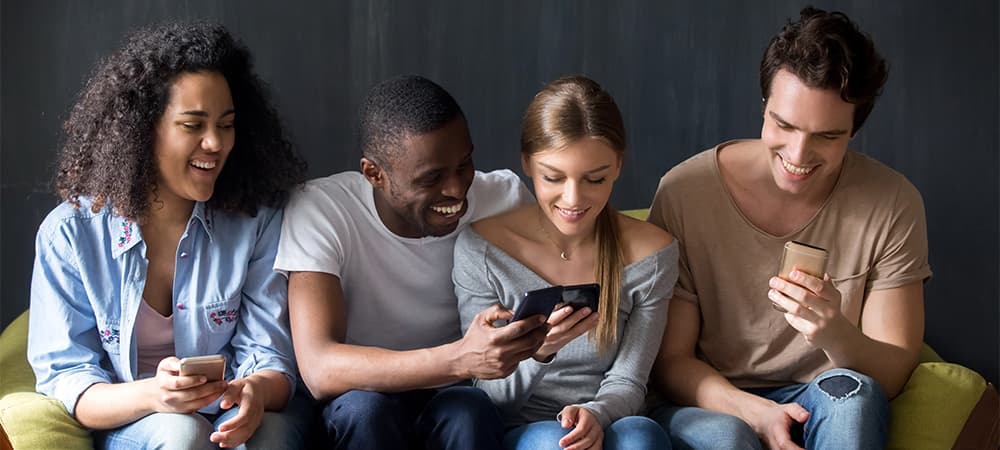

## Overview

Syriatel Mobile Telecom is a service pervider that currently serves more than 8 million people today having 199 international roaming partners in 116 countries.  As a data scientist, I am currently creating a model to predict when might customers churn.  By building a model to help predict when customers will deter away from the service I can either offer additional advice to for the company to allocate resources to make the customer happier and improve our services that may be not opitimal at the time.  This model can also provide wisedom where improvements to the company may need to be done. 

## Business Problem

Service providers strive to maintain a healthy balance between gaining new customers while minimizing those who switch providers.  Syriatel provides service to more than 8 million people today and in our data set 15% of customers churned during this time period.  If this sample dataset somewhat resembles the total dataset this company has lost over a million customers.  As a business we want to maximize profit where it can be done without making unhappy customers, so one place this can be done is the retention rate of customers.  With our predictive model, we will improve features in our business that seem to have a correlation with leaving customers and at the same time offer additional support where our model predicted to customers who are considering leaving our service.  

## Navigation

Follow through these notebooks in order to follow workflow.  They can be found in the workspace folder in this repository.

1. [Data Cleaning and Exploratory Data Analysis](./Data&#32;Cleaning&#32;and&#32;Exploratory&#32;Data&#32;Analysis.ipynb)

2. [Model Building](./Model&#32;Building.ipynb)

3. [Feature Importance Analysis](./Feature&#32;Importance&#32;Analysis.ipynb)

.

.

.

# Model Building

import libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

loaded in cleaned dataframe from Exploratory Data Analysis in Jupyter Notebook folder in this repository

In [2]:
df = pd.read_csv('../data/clean_df.csv', index_col=0)
# loaded up cleaned data from the data cleaning notebook and had two index colums so set to only have 1

In [3]:
df.info() #self check that the dataframe loaded correctly with the changes done in the Data cleaning notebook

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   int64  
 4   voice mail plan         3333 non-null   int64  
 5   number vmail messages   3333 non-null   int64  
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve calls         3333 non-null   int64  
 9   total eve charge        3333 non-null   float64
 10  total night calls       3333 non-null   int64  
 11  total night charge      3333 non-null   float64
 12  total intl calls        3333 non-null   int64  
 13  total intl charge       3333 non-null   float64
 14  customer service calls  3333 non-null   

In [4]:
X = df.drop(columns='churn') #removing the target
y = df.churn #isolating the target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3) #performing train test split

.

## Creating components for that will be needed for the `ImPipeline()`

### Contructing column converter

In [5]:
cat_cols = df[['state','area code']] #categorie columns

#binary_cols = df[['international plan', 'voice mail plan']] (doesnt need to be converted bc already in 1 and 0s)

num_cols = df.drop(columns=['state','area code', 'churn', 'international plan', 'voice mail plan']) 
#dropped categorical, binary, and target columns

customer service calls could be treated as an ordinal column, but I am not using it as so.

In [6]:
subpipe_num = Pipeline(steps=[('ss', StandardScaler())]) #subpipe for numerical to scale
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))]) #subpipe for categoricals to OHE

In [7]:
ct = ColumnTransformer(transformers= [
    ('subpipe_num', subpipe_num, num_cols.columns),
    ('subpipe_cat', subpipe_cat, [0,2])
], remainder='passthrough')  #passthrough adds the binary to the ct

In [8]:
pd.DataFrame(ct.fit_transform(X_train)) #observing my output of my column transformer

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,0.527291,-0.582315,1.682410,-0.416881,1.120060,-0.302652,-2.121425,-0.085379,0.204352,-0.606383,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.376394,-0.582315,-1.691942,-1.055485,-1.906901,-0.649130,-0.108357,-0.129149,0.613876,-0.181249,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.023776,1.547862,1.329865,0.615205,-0.897914,-0.479333,-0.005122,0.111587,-0.614695,-0.473528,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.151564,-0.582315,0.070779,1.132324,0.867814,-1.433868,-0.418060,-0.312984,0.613876,0.536165,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.429037,-0.582315,1.279502,0.403413,-0.696116,-0.720261,-0.830997,-0.120395,0.613876,0.071175,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,-0.349406,-0.582315,0.423323,0.790445,-0.696116,-1.422395,-0.882614,1.731084,-0.205172,1.545859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2495,-0.574842,-0.582315,-0.785400,0.241074,0.262421,-0.552759,0.975603,-1.415993,-1.433743,-0.008538,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2496,-1.025715,-0.582315,0.876594,0.255050,0.514668,-2.250729,1.749860,0.168488,1.432923,1.067583,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2497,-0.073873,-0.582315,0.322596,-1.957485,0.161523,-0.275118,0.511049,-0.514327,-0.205172,0.111031,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


.

### SMOTE

In [9]:
df.churn.value_counts(), df.churn.value_counts(normalize=True) #returns the value_counts and percent of the value_counts

(0    2850
 1     483
 Name: churn, dtype: int64,
 0    0.855086
 1    0.144914
 Name: churn, dtype: float64)

There is a class imbalance so will use SMOTE to generate synthetic data to supplement the minority class in pipelines

.

**Baseline model/ Dummy model**

In [10]:
imb_pipe_dummy= ImPipeline(steps=[('ct',ct), 
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('dummy', DummyClassifier())])

imb_pipe_dummy.fit(X_train, y_train)
print(f'cv = {cross_val_score(imb_pipe_dummy, X_train, y_train).mean()} , train = {imb_pipe_dummy.score(X_train, y_train)}')

cv = 0.8527414829659319 , train = 0.8527410964385754


.

## Looking at a variety of different types of algorithms

**Overview!**

I went through multiple different model defaults once and did additional hyperparameter tuning on the ones I wanted to look at more. 

Ran each model with Pipelines to avoid data leakage with cross validation.

I think the VotingClassifier is cool and thats why I messed around with the weights, but it was not as desireable to dig in to deeper compared to RandomForestClassifier and GradientBoostingClassifier.

The default models that yielded the best cross val scores were the RandomForestClassifier and GradientBoostingClassifier.  I proceeded to run grid searches on both of these models.

After exploring the models the GradientBoostingClassifier after being hyperparameter turned yielded the best cross value score.

.

**LogisticRegression model**

Default using Pipeline

In [11]:
imb_pipe_logreg = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('logreg',LogisticRegression(random_state=3, max_iter=5000))]) 

#was recieving interation warnings so increased it

imb_pipe_logreg.fit(X_train, y_train)
print(f'cv = {cross_val_score(imb_pipe_logreg, X_train, y_train).mean()} , train = {imb_pipe_logreg.score(X_train, y_train)}')

cv = 0.7655102204408818 , train = 0.7847138855542217


.

**KNneighborsClassifier model**

Default using Pipeline

In [12]:
imb_pipe_knn = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('knn',KNeighborsClassifier())])

imb_pipe_knn.fit(X_train, y_train)
print(f'cv = {cross_val_score(imb_pipe_knn, X_train, y_train).mean()} , train = {imb_pipe_knn.score(X_train, y_train)}')

cv = 0.7278917835671342 , train = 0.8443377350940376


.

**DecisionTreeClassifier model**

Default using Pipeline

In [13]:
imb_pipe_dtc = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('dtc',DecisionTreeClassifier(random_state=3))])

imb_pipe_dtc.fit(X_train, y_train)
print(f'cv = {cross_val_score(imb_pipe_dtc, X_train, y_train).mean()} , train = {imb_pipe_dtc.score(X_train, y_train)}')

cv = 0.8967567134268537 , train = 1.0


.

**VotingClassifier model**

Default using Pipeline

In [14]:
avg = VotingClassifier(estimators=[
    ('logreg',LogisticRegression(random_state=3, max_iter=5000)),
    ('knn',KNeighborsClassifier()),
    ('dtc', DecisionTreeClassifier(random_state=3))])


imb_pipe_vote = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('vote', avg)])
imb_pipe_vote.fit(X_train, y_train)
print(f'cv = {cross_val_score(imb_pipe_vote, X_train, y_train).mean()} , train = {imb_pipe_vote.score(X_train, y_train)}')

cv = 0.8591422845691383 , train = 0.9455782312925171


I think the VotingClassifier is cool and thats why I messed around with the weights, but this default model was not as good as some other models so will not be used in final model.

In [15]:
avg = VotingClassifier(estimators=[
    ('logreg',LogisticRegression(random_state=3, max_iter=5000)),
    ('knn',KNeighborsClassifier()),
    ('dtc', DecisionTreeClassifier(random_state=3))
], weights=[.25,.25,.5])


imb_pipe_vote1 = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('vote', avg)])
imb_pipe_vote1.fit(X_train, y_train)
print(f'cv = {cross_val_score(imb_pipe_vote1, X_train, y_train).mean()} , train = {imb_pipe_vote1.score(X_train, y_train)}')

cv = 0.9107607214428859 , train = 1.0


Adding weights increased the cross val score.  Wanting to see how the variations may affect the model.

In [16]:
avg = VotingClassifier(estimators=[
    ('logreg',LogisticRegression(random_state=3, max_iter=5000)),
    ('knn',KNeighborsClassifier()),
    ('dtc', DecisionTreeClassifier(random_state=3))
], weights=[.20,.20,.6])


imb_pipe_vote2 = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('vote', avg)])
imb_pipe_vote2.fit(X_train, y_train)
print(f'cv = {cross_val_score(imb_pipe_vote2, X_train, y_train).mean()} , train = {imb_pipe_vote2.score(X_train, y_train)}')

cv = 0.8967567134268537 , train = 1.0


To much weight on dtc lowered from previous. Now lets see how giving more weight to the 2 estimators affect the cv_score

In [17]:
avg = VotingClassifier(estimators=[
    ('logreg',LogisticRegression(random_state=3, max_iter=5000)),
    ('knn',KNeighborsClassifier()),
    ('dtc', DecisionTreeClassifier(random_state=3))
], weights=[.5,.25,.25])


imb_pipe_vote3 = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('vote', avg)])
imb_pipe_vote3.fit(X_train, y_train)
print(f'cv = {cross_val_score(imb_pipe_vote3, X_train, y_train).mean()} , train = {imb_pipe_vote3.score(X_train, y_train)}')

cv = 0.8527446893787575 , train = 0.9103641456582633


In [18]:
avg = VotingClassifier(estimators=[
    ('logreg',LogisticRegression(random_state=3, max_iter=5000)),
    ('knn',KNeighborsClassifier()),
    ('dtc', DecisionTreeClassifier(random_state=3))
], weights=[.25,.5,.25])


imb_pipe_vote4 = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('vote', avg)])
imb_pipe_vote4.fit(X_train, y_train)
print(f'cv = {cross_val_score(imb_pipe_vote4, X_train, y_train).mean()} , train = {imb_pipe_vote4.score(X_train, y_train)}')

cv = 0.8583414829659318 , train = 0.9455782312925171


Best Voting model so far was with the most weight on the dtc.  Lets see how using a RandomForestClassifier,  a different tree estimator compares. 

In [19]:
avg = VotingClassifier(estimators=[
    ('logreg',LogisticRegression(random_state=3, max_iter=5000)),
    ('knn',KNeighborsClassifier()),
    ('rfc', RandomForestClassifier(random_state=3))
], weights=[.25,.25,.5])


imb_pipe_vote5 = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('vote', avg)])
imb_pipe_vote5.fit(X_train, y_train)
print(f'cv = {cross_val_score(imb_pipe_vote5, X_train, y_train).mean()} , train = {imb_pipe_vote5.score(X_train, y_train)}')

cv = 0.9231655310621243 , train = 1.0


Best cv score yield so far with VotingClassifier.

.

**RandomForestClassifier model**

Default using Pipeline

In [20]:
imb_pipe_rfc = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('rfc',RandomForestClassifier(random_state=3))])

imb_pipe_rfc.fit(X_train, y_train)
print(f'cv = {cross_val_score(imb_pipe_rfc, X_train, y_train).mean()} , train = {imb_pipe_rfc.score(X_train, y_train)}')

cv = 0.9263679358717436 , train = 1.0


Best score so far lets explore with a grid search.

In [21]:
parameters = {'rfc__criterion': ['gini', 'entropy'],
          'rfc__max_depth': [2, 5, 10, 100]}


gs_rfc = GridSearchCV(estimator=imb_pipe_rfc,
                 param_grid=parameters,
                 cv=5)

In [22]:
gs_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['account length', 'number vmail messages', 'total day calls',
       'total day charge', 'total eve calls', 'total eve charge',
       'total night calls', 'total night charge', 'total intl calls',
       'total intl charge', 'customer service calls'],
      dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
               

In [23]:
gs_rfc.best_score_ #returns the grid search best score.

0.934767134268537

In [24]:
gs_rfc.best_params_ #returns the grid search best parameters.

{'rfc__criterion': 'entropy', 'rfc__max_depth': 100}

Second best algorithym behind the GradientBoosterClassifier

.

**GradientBoostingClassifier model**

Default using Pipeline

In [25]:
imb_pipe_gbc = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('gbc', GradientBoostingClassifier(random_state=3))])

imb_pipe_gbc.fit(X_train, y_train)
print(f'cv = {cross_val_score(imb_pipe_gbc, X_train, y_train).mean()} , train = {imb_pipe_gbc.score(X_train, y_train)}')

cv = 0.9291695390781562 , train = 0.952781112444978


Higest defualt model.  Will run a gridsearch.

In [26]:
parameters = {'gbc__loss': ['deviance', 'exponential'],
          'gbc__max_depth': [2, 5, 10]}


gs2 = GridSearchCV(estimator=imb_pipe_gbc,
                 param_grid=parameters,
                 cv=5)

In [27]:
gs2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['account length', 'number vmail messages', 'total day calls',
       'total day charge', 'total eve calls', 'total eve charge',
       'total night calls', 'total night charge', 'total intl calls',
       'total intl charge', 'customer service calls'],
      dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
               

In [28]:
gs2.best_params_ #returns the grid search best parameters.

{'gbc__loss': 'exponential', 'gbc__max_depth': 5}

In [29]:
gs2.best_score_ #returns the grid search best score.

0.9451735470941884

Best model in this notebook.  This will be the final model.

.

.

.

## Final Model on the testing data

C:\Users\weesn\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 720x360 with 0 Axes>

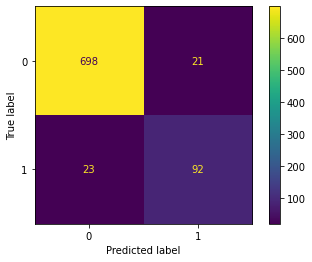

In [40]:
plt.figure(figsize=(10,5))
plot_confusion_matrix(gs2.best_estimator_, X_test, y_test)
plt.savefig('../images/confusion_matrix.png');

Calculating the performance metrics of our Final Model

In [31]:
acc = accuracy_score(y_test, gs2.best_estimator_.predict(X_test))
rec = recall_score(y_test, gs2.best_estimator_.predict(X_test))
pre = precision_score(y_test, gs2.best_estimator_.predict(X_test))
f1 = f1_score(y_test, gs2.best_estimator_.predict(X_test))
print(f"""
Final model's accuracy on the test set is {round(acc, 2)}. \n
Final model's precision on the test set is {round(pre, 2)} \n
Final model's recall on the test set is {round(rec, 2)} \n
Final model's f1-score on the test is {round(f1, 2)}.
""")


Final model's accuracy on the test set is 0.95. 

Final model's precision on the test set is 0.81 

Final model's recall on the test set is 0.8 

Final model's f1-score on the test is 0.81.



Model does well on testing data.  Ideally when trying to improve model in the future I would like to reduce the false negative and false positive.

.

.

.

## Model Improvement 

Each algorithm type is shown below in the graph.  The models that aren't labled as tuned were the models run with defualt parameters.  The tuned models are the best score from the hyperparameter tuning groups.

In [32]:
model_devolpment = {'LogisticRegression' : round(cross_val_score(imb_pipe_logreg, X_train, y_train).mean(),3),
                   'KNneighborsClassifer': round(cross_val_score(imb_pipe_knn, X_train, y_train).mean(), 3),
                   'DecisionTreeClassifier': round(cross_val_score(imb_pipe_dtc, X_train, y_train).mean(), 3),
                   'VotingClassifier': round(cross_val_score(imb_pipe_vote, X_train, y_train).mean(), 3),
                   'VotingClassifier tuned': round(cross_val_score(imb_pipe_vote5, X_train, y_train).mean(), 3),
                   'RandomForestClassifier': round(cross_val_score(imb_pipe_rfc, X_train, y_train).mean(),3),
                   'RandomForestClassifier tuned' : round(gs_rfc.best_score_, 3),
                   'GradientBoostingClassifier': round(cross_val_score(imb_pipe_gbc, X_train, y_train).mean(),3),
                   'GradientBoostingClassifier tuned' : round(gs2.best_score_, 3)}
model_devolpment

{'LogisticRegression': 0.766,
 'KNneighborsClassifer': 0.728,
 'DecisionTreeClassifier': 0.897,
 'VotingClassifier': 0.859,
 'VotingClassifier tuned': 0.923,
 'RandomForestClassifier': 0.926,
 'RandomForestClassifier tuned': 0.935,
 'GradientBoostingClassifier': 0.929,
 'GradientBoostingClassifier tuned': 0.945}

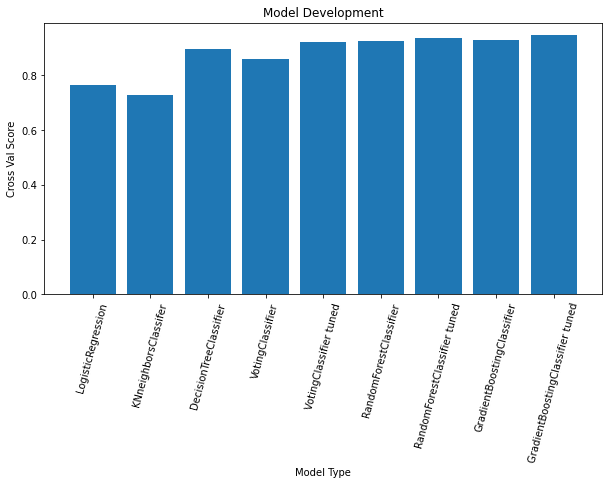

In [48]:
plt.figure(figsize=(10,5))
plt.bar(model_devolpment.keys(), model_devolpment.values())

plt.title('Model Development')
plt.xlabel('Model Type')
plt.ylabel('Cross Val Score')

plt.xticks(rotation=75)
plt.savefig('../images/model_improvement.jpg',bbox_inches="tight");

GradientBoosterClassifier tuned was my best predictive model.

.

.

.

## Feature Importances

Looking into the Final model feature importances.  These parameters were found through the gs2.best_params_

In [34]:
Final_model = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('gbc', GradientBoostingClassifier(loss='exponential', max_depth=5, random_state=3))])

Final_model.fit(X_train, y_train)
cross_val_score(Final_model, X_train, y_train).mean(), Final_model.score(X_train, y_train)

(0.9451735470941884, 0.9787915166066427)

Model is Overfit.  Whenever I get the time to improve the model work on making a better fit model.

Getting the feature information from out Final_model

In [35]:
gbc_feature_names = Final_model[:-1].get_feature_names_out() #feature names after passed through the column transformer

In [36]:
gbc_feature_importance = Final_model.named_steps['gbc'].feature_importances_ #feature importance

In [37]:
len(Final_model[:-1].get_feature_names_out()) == len(Final_model.named_steps['gbc'].feature_importances_)
#making sure the lengths are the same before combing them into a pd.DataFrame

True

In [38]:
best_feature_df = pd.DataFrame({'feature_names' : gbc_feature_names,  'feature_importance' : gbc_feature_importance})
# feature_names and feature_importance are both in the correct order with eachother so can combine into dataframe

In [39]:
best_feature_df.sort_values('feature_importance', ascending=False)
#sorted the importance from most to least

,feature_names,feature_importance
10,subpipe_num__customer service calls,2.259679e-01
3,subpipe_num__total day charge,2.248785e-01
65,remainder__international plan,1.608697e-01
5,subpipe_num__total eve charge,8.228862e-02
8,subpipe_num__total intl calls,5.066164e-02
...,...,...
47,subpipe_cat__state_OK,5.206200e-06
44,subpipe_cat__state_NV,3.420319e-17
49,subpipe_cat__state_PA,0.000000e+00
27,subpipe_cat__state_KS,0.000000e+00


Top 3 Feature importances were customer service calls, total day charge, and international plan.  **Continue onto Feature Important Analysis notebook** to follow analysis in these 3 feature importances. 